# Imports

In [ ]:
import re
import unicodedata
from bs4 import BeautifulSoup
import html
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Chargement des données

In [ ]:
# Création d'un dossier appelé data
!mkdir data

# Téléchargement du fichier contenant les fanfictions et leurs métadonnées
!wget -P data https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/fanfics_prep_fusion/fanfics_complet.csv

--2025-03-25 17:02:03--  https://gitlab.unistra.fr/paulinemoreau/memoire/-/raw/main/data/vrac/fanfics_prep_fusion/fanfics_complet.csv
Resolving gitlab.unistra.fr (gitlab.unistra.fr)... 130.79.254.48
Connecting to gitlab.unistra.fr (gitlab.unistra.fr)|130.79.254.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249567183 (238M) [text/plain]
Saving to: ‘data/fanfics_complet.csv’

fanfics_complet.csv 100%[===================>] 238.00M  12.2MB/s    in 35s     

2025-03-25 17:02:39 (6.78 MB/s) - ‘data/fanfics_complet.csv’ saved [249567183/249567183]



In [ ]:
df_fanfic = pd.read_csv("data/fanfics_complet.csv", encoding="utf-8")

In [ ]:
len(df_fanfic)

3653

# Fanfictions "vides"

### Vérifier si certains body de fanfiction sont vides

In [ ]:
# df_vide contient les lignes où "body" est vide ou ne contient que des espaces s'il y en a
df_vide = df_fanfic[df_fanfic['body'].isna() | df_fanfic['body'].str.strip().eq('')]

# Nombre de lignes vides dans la colonne 'body'
print(f"Nombre de lignes avec 'body' vide : {df_vide.shape[0]}")

Nombre de lignes avec 'body' vide : 5


In [ ]:
df_vide

,work_id,tag,title,author,rating,category,fandom,relationship,character,additional tags,...,status date,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body
25,63197812,Fluff,Un matin tout tranquille,['Madame_Thyst (Mad_Amethyst)'],Mature,M/M,Asterix le Gaulois | The Adventures of Asterix...,Asterix | Asterix/Julius Caesar,"Asterix | Asterix, Jules Cesar | Julius Caesar","Fluff, Fanart",...,2025-02-18,0,1/1,4.0,10,NaN,88,"['XxXLiizuXxX', 'stormyskieslovessmussy', 'Jes...",[],\n\n
184,61760080,Fluff,Douceur,"['Douc-e_Mutant-e (Sweety_Mutant)', 'Sweety_Mu...",General Audiences,Gen,Hades (Supergiant Games Video Games),Dusa & Megaera (Hades Video Game),"Dusa (Hades Video Game), Megaera (Hades Video ...","Fanart, Fluff, Warm and Fuzzy Feelings, Fur",...,2024-12-29,0,1/1,4.0,6,NaN,34,"['Jagodzianka', 'Mad_Amethyst', 'BethLange', '...",[],\n\n
912,63022777,Angst,Ton Reflet Dans Le Miroir,"['Douc-e_Mutant-e (Sweety_Mutant)', 'Sweety_Mu...",General Audiences,F/F,Black Sails,Eleanor Guthrie/Max,"Max (Black Sails), Eleanor Guthrie","Fanart, Digital Art, Ghosts, Light Angst, Angs...",...,2025-02-13,0,1/1,2.0,7.0,NaN,46,"['whiteshipnightjar', 'cakushi', 'Linnea_Ancal...",[],\n\n
1504,56266516,Angst,Frissons,['BourbonOnTheRocks'],General Audiences,F/M,L'art du crime | The Art of Crime (TV),Florence Chassagne/Antoine Verlay,"Florence Chassagne, Antoine Verlay","Fanvids, Unrequited Love, Angst, Grief/Mournin...",...,2024-05-29,0,1/1,4.0,9.0,NaN,160,"['bookssunshines', 'useless_fangirl_does_fanar...",[],NaN
1823,50961304,Angst,Spasi menia! [FANVID],['Fausthaus'],Teen And Up Audiences,M/M,Hana Yori Dango | Boys Over Flowers (Japan TV ...,Doumyouji Tsukasa/Hanazawa Rui,"Doumyouji Tsukasa, Hanazawa Rui","Drama, Angst, Fanvids, Embedded Video, Video, ...",...,2023-10-19,0,1/1,NaN,3.0,1.0,35,[],[],NaN


### Suppression des lignes vides qui ne serviront pas

In [ ]:
# Supprimer les lignes avec NaN
df_fanfic_no_vide = df_fanfic.dropna(subset=['body'])
# Supprimer les lignes avec des espaces uniquement
df_fanfic_no_vide = df_fanfic_no_vide[df_fanfic_no_vide['body'].str.strip().ne('')]

In [ ]:
len(df_fanfic_no_vide)

3648

# Nettoyage des textes

### Suppression des éventuelles urls

In [ ]:
def supprimer_urls(texte):
    return re.sub(r'http[s]?://\S+|www\.\S+', '', texte)

### Supression des éventuelles balises HTML

In [ ]:
def supprimer_html(texte):
    return BeautifulSoup(texte, "html.parser").get_text()

### Normalisation des caractères

In [ ]:
def normaliser_caracteres(texte):
    return unicodedata.normalize("NFKC", texte)

### Remplacement des entités HTML courantes

In [ ]:
def remplacer_entites_html(texte):
    return html.unescape(texte)

### Gérer les sauts de ligne multiples

In [ ]:
def nettoyer_retours_ligne(texte):
    # Remplace plusieurs sauts de ligne par un seul
    return re.sub(r'\n+', '\n', texte).strip()

### Fonction récapitulative

In [ ]:
def nettoyer_fanfiction(texte):
    texte = supprimer_urls(texte)
    texte = supprimer_html(texte)
    texte = normaliser_caracteres(texte)
    texte = remplacer_entites_html(texte)
    texte = nettoyer_retours_ligne(texte)

    return texte

### Appliquer le nettoyage sur les textes des fanfictions




In [ ]:
# Appliquer le nettoyage sur la colonne "body" qui contient les textes
df_fanfic_no_vide["body_clean"] = df_fanfic_no_vide["body"].apply(nettoyer_fanfiction)

In [ ]:
df_fanfic_no_vide.head()

,work_id,tag,title,author,rating,category,fandom,relationship,character,additional tags,...,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body,body_clean
0,63563206,Fluff,Nuit etoile,['Lady_Meg_666'],General Audiences,M/M,Harry Potter - J. K. Rowling,Sirius Black/Remus Lupin,"Sirius Black, Remus Lupin","Established Relationship, Fluff, Domestic Fluf...",...,241,1/1,1.0,NaN,NaN,14,[],[],"<< Regarde, murmure Sirius en montrant le ciel...","<< Regarde, murmure Sirius en montrant le ciel..."
1,63528274,Fluff,Je le deteste,['wilk'],Not Rated,M/M,Hawaii Five-0 (2010),"Steve McGarrett/Danny ""Danno"" Williams","Danny ""Danno"" Williams, Steve McGarrett",Fluff,...,100,1/1,1.0,5,NaN,59,"['MommaJ', 'WhiteShiro']",[],Danny deteste vraiment Steve : a peine deux jo...,Danny deteste vraiment Steve : a peine deux jo...
2,63513724,Fluff,Camomille,['MyLovelyKitchenSinkDrama'],General Audiences,M/M,Guns N' Roses,Axl Rose/Izzy Stradlin,"Izzy Stradlin, Axl Rose","Domestic Fluff, Self-Indulgent, Trans Male Cha...",...,311,1/1,4.0,5,NaN,33,"['AllenKune', 'Sawcha', 'Azryel']",[],Izzy n'entend aucun bruit venir de l'appart qu...,Izzy n'entend aucun bruit venir de l'appart qu...
3,63507442,Fluff,Le Sel sur ses Levres,['Kayukiya'],Explicit,M/M,Captive Prince - C. S. Pacat,Damen/Laurent (Captive Prince),"Damen (Captive Prince), Laurent (Captive Prince)","POV Damen (Captive Prince), Caring Damen (Capt...",...,"5,602",1/1,NaN,6,NaN,88,"['emysterieuse', 'Shteakum', 'Azulina33']",[],\n\nLa jument a la superbe robe isabelle se d...,La jument a la superbe robe isabelle se dressa...
4,63508948,Fluff,L'heureux destinataire,['Lady_Meg_666'],General Audiences,M/M,Teen Wolf (TV),Liam Dunbar/Theo Raeken,"Liam Dunbar, Theo Raeken","Letter, love letter, Romantic Fluff",...,429,1/1,NaN,1,NaN,41,['Myauada'],[],"""Je ne sais pas vraiment quoi faire. Depuis ma...","""Je ne sais pas vraiment quoi faire. Depuis ma..."


# Taille des fanfictions

Les fanfictions peuvent être de tailles très variées.
Aussi, au-delà de poser un problème d'équilibre dans le corpus, les fanfictions très longues empêchent le bon fonctionnement de l'analyse en causant notamment des problèmes de mémoire (RAM).

Pour remédier à cela, j'étudie la taille des différentes fanfictions pour pouvoir fixer une limite maximale de caractères.

In [ ]:
# Calculer la longueur maximale des textes dans la colonne 'body_clean'
max_length = df_fanfic_no_vide['body_clean'].apply(len).max()

print(f"La longueur maximale des textes dans la colonne 'body_clean' est de {max_length} caractères.")


La longueur maximale des textes dans la colonne 'body_clean' est de 7593227 caractères.


In [ ]:
# Colonne contenant le nombre de caractères des fanfictions
df_fanfic_no_vide["nb_caracteres"] = df_fanfic_no_vide["body_clean"].apply(len)

# Affichage des informations sur les longueurs de "body_clean" (ex: moyenne, médiane, écart-type, max, min...)
df_fanfic_no_vide["nb_caracteres"].describe().round()


,nb_caracteres
count,3648.0
mean,66669.0
std,273673.0
min,18.0
25%,3245.0
50%,10032.0
75%,35386.0
max,7593227.0


In [ ]:
# Calculer le nombre de fanfictions avec plus de 200,000 caractères
long_fanfics = df_fanfic_no_vide[df_fanfic_no_vide['body_clean'].apply(len) > 200000]

# Afficher le nombre total de fanfictions qui dépassent la limite
total_long_fanfics = len(long_fanfics)
print(f"Nombre total de fanfictions avec plus de 200,000 caractères : {total_long_fanfics}")

# Compter le nombre de fanfictions par tag
tag_counts = long_fanfics['tag'].value_counts()

# Afficher le nombre de fanfictions par tag
print("\nNombre de fanfictions par tag qui dépassent la limite :")
print(tag_counts)

Nombre total de fanfictions avec plus de 200,000 caractères : 269

Nombre de fanfictions par tag qui dépassent la limite :
tag
Hurt/Comfort         98
Angst                68
Enemies to lovers    50
Friends to lovers    38
Fluff                15
Name: count, dtype: int64


In [ ]:
# Calculer le nombre de fanfictions avec plus de 300,000 caractères
long_fanfics = df_fanfic_no_vide[df_fanfic_no_vide['body_clean'].apply(len) > 300000]

# Afficher le nombre total de fanfictions qui dépassent la limite
total_long_fanfics = len(long_fanfics)
print(f"Nombre total de fanfictions avec plus de 300,000 caractères : {total_long_fanfics}")

# Compter le nombre de fanfictions par tag
tag_counts = long_fanfics['tag'].value_counts()

# Afficher le nombre de fanfictions par tag
print("\nNombre de fanfictions par tag qui dépassent la limite :")
print(tag_counts)

Nombre total de fanfictions avec plus de 300,000 caractères : 174

Nombre de fanfictions par tag qui dépassent la limite :
tag
Hurt/Comfort         57
Angst                46
Enemies to lovers    33
Friends to lovers    29
Fluff                 9
Name: count, dtype: int64


In [ ]:
# Calculer le nombre de fanfictions avec plus de 400,000 caractères
long_fanfics = df_fanfic_no_vide[df_fanfic_no_vide['body_clean'].apply(len) > 400000]

# Afficher le nombre total de fanfictions qui dépassent la limite
total_long_fanfics = len(long_fanfics)
print(f"Nombre total de fanfictions avec plus de 400,000 caractères : {total_long_fanfics}")

# Compter le nombre de fanfictions par tag
tag_counts = long_fanfics['tag'].value_counts()

# Afficher le nombre de fanfictions par tag
print("\nNombre de fanfictions par tag qui dépassent la limite :")
print(tag_counts)

Nombre total de fanfictions avec plus de 400,000 caractères : 130

Nombre de fanfictions par tag qui dépassent la limite :
tag
Hurt/Comfort         44
Angst                34
Enemies to lovers    25
Friends to lovers    18
Fluff                 9
Name: count, dtype: int64


In [ ]:
# Calculer le nombre de fanfictions avec plus de 500,000 caractères
long_fanfics = df_fanfic_no_vide[df_fanfic_no_vide['body_clean'].apply(len) > 500000]

# Afficher le nombre total de fanfictions qui dépassent la limite
total_long_fanfics = len(long_fanfics)
print(f"Nombre total de fanfictions avec plus de 500,000 caractères : {total_long_fanfics}")

# Compter le nombre de fanfictions par tag
tag_counts = long_fanfics['tag'].value_counts()

# Afficher le nombre de fanfictions par tag
print("\nNombre de fanfictions par tag qui dépassent la limite :")
print(tag_counts)

Nombre total de fanfictions avec plus de 500,000 caractères : 92

Nombre de fanfictions par tag qui dépassent la limite :
tag
Hurt/Comfort         30
Angst                27
Enemies to lovers    18
Friends to lovers    12
Fluff                 5
Name: count, dtype: int64


# Diagramme boîte à moustache des tailles de fanfictions

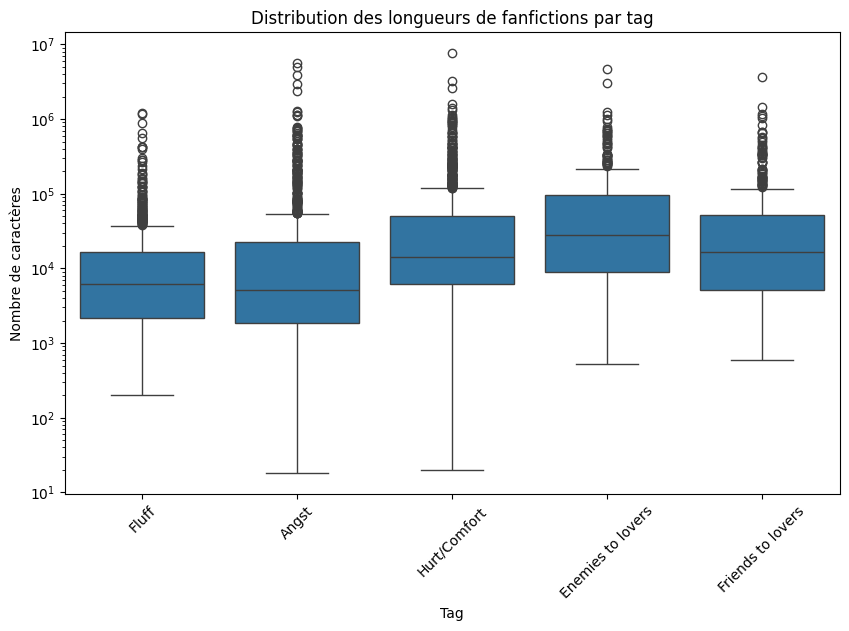

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x="tag", y="nb_caracteres", data=df_fanfic_no_vide, showfliers=True)
plt.yscale("log")
plt.xlabel("Tag")
plt.ylabel("Nombre de caractères")
plt.title("Distribution des longueurs de fanfictions par tag")
plt.xticks(rotation=45)
plt.show()

# Calcul des moyennes et écart-types des tailles des fanfictions de chaque tag

In [ ]:
# Calcul des moyennes et écart-types des longueurs
moyennes = df_fanfic_no_vide.groupby("tag")["nb_caracteres"].mean()
ecarts_types = df_fanfic_no_vide.groupby("tag")["nb_caracteres"].std()

# Affichage des résultats
print("Moyennes des tailles de fanfictions par tag :")
print(moyennes.round())
print("\nÉcart-types des tailles de fanfictions par tag :")
print(ecarts_types.round())


Moyennes des tailles de fanfictions par tag :
tag
Angst                 65154.0
Enemies to lovers    133682.0
Fluff                 24444.0
Friends to lovers     70676.0
Hurt/Comfort          81091.0
Name: nb_caracteres, dtype: float64

Écart-types des tailles de fanfictions par tag :
tag
Angst                318654.0
Enemies to lovers    376102.0
Fluff                 83475.0
Friends to lovers    215482.0
Hurt/Comfort         309595.0
Name: nb_caracteres, dtype: float64


Au vu des longueurs des fanfictions dans les différents tags, je décide de limiter les fanfictions Fluff, Hurt/Comfort et Angst à 200 000 caractères qui semble être une longueur raisonnable.

Pour Enemies to lovers et Friends to lovers, je décide d'augmenter cette limite à 500 000, car j'ai pu collecter beaucoup moins de fanfictions de ce type (par exemple, supprimer 50 fanfictions Enemies to lovers viendrait à supprimer environ 25 % de leur total alors qu'elles sont déjà les moins représentées).

### Suppression des fanfictions trop longues

In [ ]:
# Filtrer les fanfictions "Fluff", "Angst", et "Hurt/Comfort" avec <= 200 000 caractères
df_fluff_angst_hurt = df_fanfic_no_vide[(df_fanfic_no_vide["tag"].isin(["Fluff", "Angst", "Hurt/Comfort"])) &
                         (df_fanfic_no_vide["nb_caracteres"] <= 200_000)]

# Filtrer les fanfictions "Enemies to lovers" et "Friends to lovers" avec <= 500 000 caractères
df_etl_ftl = df_fanfic_no_vide[(df_fanfic_no_vide["tag"].isin(["Enemies to lovers", "Friends to lovers"])) &
                (df_fanfic_no_vide["nb_caracteres"] <= 500_000)]

# Fusionner les deux ensembles
df_final_limit = pd.concat([df_fluff_angst_hurt, df_etl_ftl])

In [ ]:
# Compter le nombre de fanfictions par tag
tag_counts = df_final_limit['tag'].value_counts()

# Afficher le résultat
print(f"Nombre de fanfictions par tag après prétraitements:\n")
print(tag_counts)

Nombre de fanfictions par tag après prétraitements:

tag
Angst                935
Hurt/Comfort         934
Fluff                805
Friends to lovers    494
Enemies to lovers    269
Name: count, dtype: int64


In [ ]:
len(df_final_limit)

3437

In [ ]:
df_final_limit.head()

,work_id,tag,title,author,rating,category,fandom,relationship,character,additional tags,...,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body,body_clean,nb_caracteres
0,63563206,Fluff,Nuit etoile,['Lady_Meg_666'],General Audiences,M/M,Harry Potter - J. K. Rowling,Sirius Black/Remus Lupin,"Sirius Black, Remus Lupin","Established Relationship, Fluff, Domestic Fluf...",...,1/1,1.0,NaN,NaN,14,[],[],"<< Regarde, murmure Sirius en montrant le ciel...","<< Regarde, murmure Sirius en montrant le ciel...",1413
1,63528274,Fluff,Je le deteste,['wilk'],Not Rated,M/M,Hawaii Five-0 (2010),"Steve McGarrett/Danny ""Danno"" Williams","Danny ""Danno"" Williams, Steve McGarrett",Fluff,...,1/1,1.0,5,NaN,59,"['MommaJ', 'WhiteShiro']",[],Danny deteste vraiment Steve : a peine deux jo...,Danny deteste vraiment Steve : a peine deux jo...,600
2,63513724,Fluff,Camomille,['MyLovelyKitchenSinkDrama'],General Audiences,M/M,Guns N' Roses,Axl Rose/Izzy Stradlin,"Izzy Stradlin, Axl Rose","Domestic Fluff, Self-Indulgent, Trans Male Cha...",...,1/1,4.0,5,NaN,33,"['AllenKune', 'Sawcha', 'Azryel']",[],Izzy n'entend aucun bruit venir de l'appart qu...,Izzy n'entend aucun bruit venir de l'appart qu...,1742
3,63507442,Fluff,Le Sel sur ses Levres,['Kayukiya'],Explicit,M/M,Captive Prince - C. S. Pacat,Damen/Laurent (Captive Prince),"Damen (Captive Prince), Laurent (Captive Prince)","POV Damen (Captive Prince), Caring Damen (Capt...",...,1/1,NaN,6,NaN,88,"['emysterieuse', 'Shteakum', 'Azulina33']",[],\n\nLa jument a la superbe robe isabelle se d...,La jument a la superbe robe isabelle se dressa...,35140
4,63508948,Fluff,L'heureux destinataire,['Lady_Meg_666'],General Audiences,M/M,Teen Wolf (TV),Liam Dunbar/Theo Raeken,"Liam Dunbar, Theo Raeken","Letter, love letter, Romantic Fluff",...,1/1,NaN,1,NaN,41,['Myauada'],[],"""Je ne sais pas vraiment quoi faire. Depuis ma...","""Je ne sais pas vraiment quoi faire. Depuis ma...",2412


In [ ]:
# Enregistrement
df_final_limit.to_csv("data/fanfics_clean.csv", index=False)